In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Model Libraries
from xgboost import XGBClassifier

In [2]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [3]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [4]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [5]:
df.shape

(292, 15)

In [6]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [7]:
X = df.iloc[:, 2:9]

## Train/Test Split

In [8]:
X.head(1)

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [9]:
X.shape

(292, 7)

In [10]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
model_choice = XGBClassifier()

In [13]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [14]:
## Using the best TPR threshold
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.7367280663362746).astype(bool)

In [15]:
## Using the default threshold == 0.5
y_pred = clf.predict(X_test)

In [16]:
y_pred_proba = clf.predict_proba(X_test)

In [17]:
np.round(accuracy_score(y_test, y_pred), 2)

0.87

In [18]:
y_train.value_counts(), y_test.value_counts()

(0    141
 1     54
 Name: label, dtype: int64,
 0    74
 1    23
 Name: label, dtype: int64)

In [19]:
## Confusion matrix with best TPR threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [20]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.826, 0.122)

In [21]:
tn, fp, fn, tp

(65, 9, 4, 19)

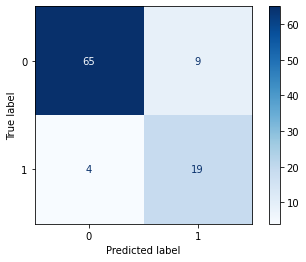

In [22]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [24]:
auc_score = auc(fpr, tpr)

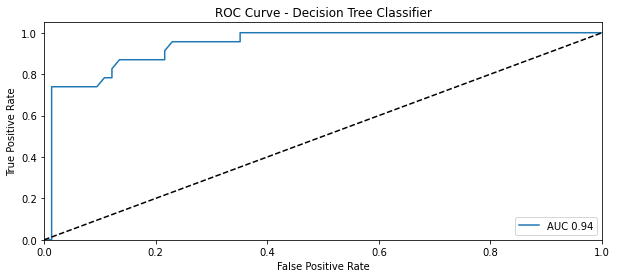

In [25]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='AUC %0.2f' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier')
plt.legend(loc="lower right")

# # find optimum thresholds
# i = np.arange(len(tpr)) # index for df
# roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: x), 'thresholds' : pd.Series(thresholds, index = i)})
# df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkred')

# # create the axis of thresholds (scores)
# ax2 = plt.gca().twinx()
# ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
# ax2.set_ylabel('Threshold',color='darkred')
# ax2.set_ylim([thresholds[-1],thresholds[0]])
# ax2.set_xlim([fpr[0],fpr[-1]])
# ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
# print(" -- Optimum Threshold -- ")
# print(df_thresh)

In [26]:
print("-- Best TPR Threshold -- ")
## Finding threshold where TPR > Optimum TPR but FPR stays below 15%
for i in range(len(fpr)):
#     if tpr[i] > 0.85 and fpr[i] < 0.20:
        print("TPR %s, FPR %s, Threshold %s" % (tpr[i], fpr[i], thresholds[i]))

-- Best TPR Threshold -- 
TPR 0.0, FPR 0.0, Threshold 1.9955404
TPR 0.0, FPR 0.013513513513513514, Threshold 0.9955403
TPR 0.7391304347826086, FPR 0.013513513513513514, Threshold 0.99515176
TPR 0.7391304347826086, FPR 0.0945945945945946, Threshold 0.6880065
TPR 0.782608695652174, FPR 0.10810810810810811, Threshold 0.632255
TPR 0.782608695652174, FPR 0.12162162162162163, Threshold 0.59168535
TPR 0.8260869565217391, FPR 0.12162162162162163, Threshold 0.5275794
TPR 0.8695652173913043, FPR 0.13513513513513514, Threshold 0.44040447
TPR 0.8695652173913043, FPR 0.14864864864864866, Threshold 0.4098118
TPR 0.8695652173913043, FPR 0.17567567567567569, Threshold 0.4027071
TPR 0.8695652173913043, FPR 0.21621621621621623, Threshold 0.29263908
TPR 0.9130434782608695, FPR 0.21621621621621623, Threshold 0.23714058
TPR 0.9565217391304348, FPR 0.22972972972972974, Threshold 0.21167427
TPR 0.9565217391304348, FPR 0.25675675675675674, Threshold 0.20015863
TPR 0.9565217391304348, FPR 0.35135135135135137, 

## Bootstrapped

In [27]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9633333333333334, Accuracy:0.8865979381443299
Iteration 1: AUC:0.8635902636916836, Accuracy:0.8041237113402062
Iteration 2: AUC:0.9033490011750881, Accuracy:0.865979381443299
Iteration 3: AUC:0.9389269406392695, Accuracy:0.865979381443299
Iteration 4: AUC:0.8708017334777898, Accuracy:0.865979381443299
Iteration 5: AUC:0.9021164021164021, Accuracy:0.8247422680412371
Iteration 6: AUC:0.9329326923076923, Accuracy:0.845360824742268
Iteration 7: AUC:0.8822222222222222, Accuracy:0.8041237113402062
Iteration 8: AUC:0.8498858447488584, Accuracy:0.7835051546391752
Iteration 9: AUC:0.9277320799059928, Accuracy:0.8762886597938144
Iteration 10: AUC:0.9500517598343685, Accuracy:0.8556701030927835
Iteration 11: AUC:0.8808316430020284, Accuracy:0.8247422680412371
Iteration 12: AUC:0.9248677248677248, Accuracy:0.8762886597938144
Iteration 13: AUC:0.9142857142857143, Accuracy:0.845360824742268
Iteration 14: AUC:0.8889840182648402, Accuracy:0.8247422680412371
Iteration 15: AUC:0.86782

Iteration 127: AUC:0.8190909090909091, Accuracy:0.7628865979381443
Iteration 128: AUC:0.8613396004700352, Accuracy:0.845360824742268
Iteration 129: AUC:0.9215628672150411, Accuracy:0.865979381443299
Iteration 130: AUC:0.8748531139835487, Accuracy:0.8350515463917526
Iteration 131: AUC:0.8852901484480431, Accuracy:0.8041237113402062
Iteration 132: AUC:0.9454545454545454, Accuracy:0.8865979381443299
Iteration 133: AUC:0.8962215320910973, Accuracy:0.8556701030927835
Iteration 134: AUC:0.9259634888438134, Accuracy:0.8556701030927835
Iteration 135: AUC:0.8775132275132275, Accuracy:0.8247422680412371
Iteration 136: AUC:0.8450342465753425, Accuracy:0.8041237113402062
Iteration 137: AUC:0.9377203290246768, Accuracy:0.865979381443299
Iteration 138: AUC:0.8980555555555555, Accuracy:0.8350515463917526
Iteration 139: AUC:0.9322751322751323, Accuracy:0.845360824742268
Iteration 140: AUC:0.9336363636363636, Accuracy:0.9072164948453608
Iteration 141: AUC:0.8851851851851852, Accuracy:0.8144329896907216

Iteration 251: AUC:0.9253819036427733, Accuracy:0.865979381443299
Iteration 252: AUC:0.9037313432835821, Accuracy:0.8350515463917526
Iteration 253: AUC:0.9224867724867726, Accuracy:0.8762886597938144
Iteration 254: AUC:0.9169154228855722, Accuracy:0.845360824742268
Iteration 255: AUC:0.8654524089306698, Accuracy:0.8041237113402062
Iteration 256: AUC:0.9189189189189189, Accuracy:0.8969072164948454
Iteration 257: AUC:0.9016227180527383, Accuracy:0.845360824742268
Iteration 258: AUC:0.9166666666666666, Accuracy:0.865979381443299
Iteration 259: AUC:0.8730022831050228, Accuracy:0.845360824742268
Iteration 260: AUC:0.8853896103896104, Accuracy:0.8350515463917526
Iteration 261: AUC:0.9076719576719576, Accuracy:0.845360824742268
Iteration 262: AUC:0.8451417004048583, Accuracy:0.8247422680412371
Iteration 263: AUC:0.9368661257606491, Accuracy:0.8762886597938144
Iteration 264: AUC:0.901058201058201, Accuracy:0.8247422680412371
Iteration 265: AUC:0.9215628672150411, Accuracy:0.8041237113402062
It

Iteration 378: AUC:0.8596969696969696, Accuracy:0.8144329896907216
Iteration 379: AUC:0.8790909090909091, Accuracy:0.865979381443299
Iteration 380: AUC:0.876657196969697, Accuracy:0.8041237113402062
Iteration 381: AUC:0.9123376623376623, Accuracy:0.8762886597938144
Iteration 382: AUC:0.9036427732079906, Accuracy:0.7731958762886598
Iteration 383: AUC:0.9066137566137566, Accuracy:0.8144329896907216
Iteration 384: AUC:0.9277950310559007, Accuracy:0.8556701030927835
Iteration 385: AUC:0.888095238095238, Accuracy:0.8041237113402062
Iteration 386: AUC:0.8756613756613757, Accuracy:0.8247422680412371
Iteration 387: AUC:0.906392694063927, Accuracy:0.8762886597938144
Iteration 388: AUC:0.9261111111111111, Accuracy:0.8762886597938144
Iteration 389: AUC:0.8946370530877573, Accuracy:0.8556701030927835
Iteration 390: AUC:0.9236186348862405, Accuracy:0.8247422680412371
Iteration 391: AUC:0.9320776255707763, Accuracy:0.8556701030927835
Iteration 392: AUC:0.8934506353861192, Accuracy:0.845360824742268


Iteration 502: AUC:0.9144444444444444, Accuracy:0.845360824742268
Iteration 503: AUC:0.8625776397515528, Accuracy:0.8247422680412371
Iteration 504: AUC:0.9450646298472386, Accuracy:0.9072164948453608
Iteration 505: AUC:0.8944444444444445, Accuracy:0.8350515463917526
Iteration 506: AUC:0.9156084656084655, Accuracy:0.8556701030927835
Iteration 507: AUC:0.9277383367139959, Accuracy:0.8247422680412371
Iteration 508: AUC:0.9277320799059929, Accuracy:0.8556701030927835
Iteration 509: AUC:0.8651026392961876, Accuracy:0.7731958762886598
Iteration 510: AUC:0.9233333333333333, Accuracy:0.865979381443299
Iteration 511: AUC:0.9057421451787648, Accuracy:0.8247422680412371
Iteration 512: AUC:0.9478787878787879, Accuracy:0.8762886597938144
Iteration 513: AUC:0.8050202839756592, Accuracy:0.7835051546391752
Iteration 514: AUC:0.9176616915422885, Accuracy:0.8556701030927835
Iteration 515: AUC:0.9192546583850931, Accuracy:0.845360824742268
Iteration 516: AUC:0.930764411027569, Accuracy:0.865979381443299


Iteration 630: AUC:0.8878424657534247, Accuracy:0.8762886597938144
Iteration 631: AUC:0.8883265856950068, Accuracy:0.845360824742268
Iteration 632: AUC:0.9362514688601645, Accuracy:0.865979381443299
Iteration 633: AUC:0.9134328358208955, Accuracy:0.8556701030927835
Iteration 634: AUC:0.9669555796316359, Accuracy:0.8969072164948454
Iteration 635: AUC:0.9044973544973545, Accuracy:0.8144329896907216
Iteration 636: AUC:0.8884132420091324, Accuracy:0.845360824742268
Iteration 637: AUC:0.8801410105757931, Accuracy:0.8247422680412371
Iteration 638: AUC:0.9025974025974026, Accuracy:0.865979381443299
Iteration 639: AUC:0.9200975081256771, Accuracy:0.8865979381443299
Iteration 640: AUC:0.8759259259259259, Accuracy:0.8350515463917526
Iteration 641: AUC:0.8848884381338744, Accuracy:0.845360824742268
Iteration 642: AUC:0.9577625570776256, Accuracy:0.8969072164948454
Iteration 643: AUC:0.8172737955346651, Accuracy:0.8350515463917526
Iteration 644: AUC:0.9166666666666666, Accuracy:0.8350515463917526


Iteration 754: AUC:0.8677777777777778, Accuracy:0.8144329896907216
Iteration 755: AUC:0.9146689497716896, Accuracy:0.8247422680412371
Iteration 756: AUC:0.8802777777777777, Accuracy:0.8247422680412371
Iteration 757: AUC:0.9045454545454545, Accuracy:0.845360824742268
Iteration 758: AUC:0.8806390977443609, Accuracy:0.8041237113402062
Iteration 759: AUC:0.849882491186839, Accuracy:0.8144329896907216
Iteration 760: AUC:0.8949771689497716, Accuracy:0.845360824742268
Iteration 761: AUC:0.8721461187214612, Accuracy:0.8350515463917526
Iteration 762: AUC:0.9154228855721392, Accuracy:0.845360824742268
Iteration 763: AUC:0.9198435972629521, Accuracy:0.8144329896907216
Iteration 764: AUC:0.9241603466955579, Accuracy:0.8762886597938144
Iteration 765: AUC:0.8770703933747411, Accuracy:0.8144329896907216
Iteration 766: AUC:0.9033333333333333, Accuracy:0.845360824742268
Iteration 767: AUC:0.9360730593607306, Accuracy:0.8762886597938144
Iteration 768: AUC:0.8897222222222222, Accuracy:0.8556701030927835


Iteration 879: AUC:0.872716894977169, Accuracy:0.8556701030927835
Iteration 880: AUC:0.9481534090909092, Accuracy:0.8865979381443299
Iteration 881: AUC:0.8757102272727273, Accuracy:0.8041237113402062
Iteration 882: AUC:0.8611925708699902, Accuracy:0.7835051546391752
Iteration 883: AUC:0.8975757575757576, Accuracy:0.8144329896907216
Iteration 884: AUC:0.9502487562189055, Accuracy:0.865979381443299
Iteration 885: AUC:0.9249429223744292, Accuracy:0.8969072164948454
Iteration 886: AUC:0.9014084507042254, Accuracy:0.865979381443299
Iteration 887: AUC:0.8944099378881987, Accuracy:0.845360824742268
Iteration 888: AUC:0.9266666666666666, Accuracy:0.8865979381443299
Iteration 889: AUC:0.8586111111111112, Accuracy:0.8247422680412371
Iteration 890: AUC:0.8748484848484848, Accuracy:0.845360824742268
Iteration 891: AUC:0.8853383458646616, Accuracy:0.8350515463917526
Iteration 892: AUC:0.9165763813651138, Accuracy:0.845360824742268
Iteration 893: AUC:0.9163533834586466, Accuracy:0.845360824742268
It

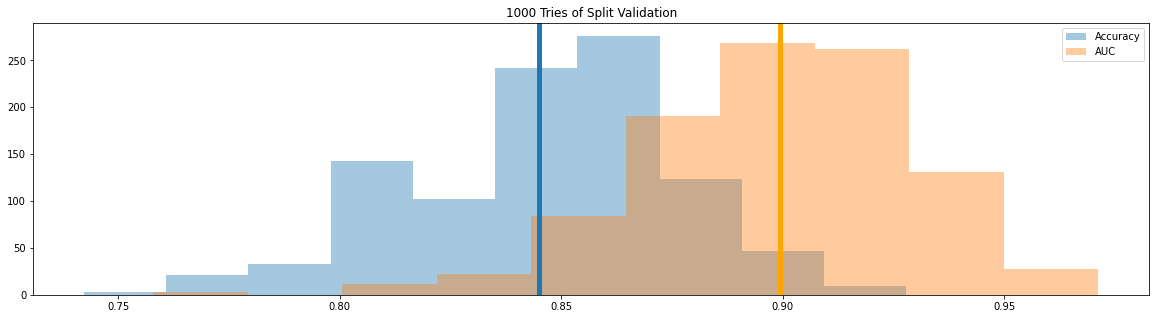

Accuracy mean: 0.85
AUC mean: 0.90


In [28]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Cross Validation & Hyperparameter Tuning

#### Process

In [30]:
## Hyperparameters
{"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight': [1, 3, 5, 7]}

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model_choice = XGBClassifier(random_state=0)

In [32]:
kfold = StratifiedKFold(n_splits=5)
cv_results = cross_val_score(model_choice, X_train, y_train, cv=kfold, scoring='roc_auc')

In [33]:
cv_results

array([0.87987013, 0.80357143, 0.86363636, 0.92207792, 0.95862069])

In [34]:
## Get the best fold train data to be tested on dataset B
i = 0
idx_train_best = []
idx_test_best = []
for train, test in kfold.split(X_train, y_train):
    if i == np.argmax(cv_results):
        idx_train_best = train
        idx_test_best = test
    i += 1

In [35]:
X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

In [36]:
X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

In [39]:
clf = model_choice.fit(X_train_best, y_train_best)
y_best_proba = clf.predict_proba(X_test_best)
fpr, tpr, thresholds = roc_curve(y_test_best, y_best_proba[:,1])
auc_score = auc(fpr, tpr)
## Check its the same as cv_results
auc_score

0.9586206896551723

In [40]:
## Test the best fold to dataset B
clf = model_choice.fit(X_train_best, y_train_best)
y_test_proba = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
## Check the AUC on dataset B
auc_score

0.9474148061104583

#### Calculate Results

In [46]:
## Results
best_fold = []
best_fold_auc = []
dataset_b_auc = []
parameter_1 = []
parameter_2 = []
parameter_3 = []
idx_train_data = []

## Hyperparameters
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ]}

## Split the data to dataset A (train) and dataset B (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Split dataset A (train) to 5 folds
kfold = StratifiedKFold(n_splits=5)

for i in range(len(params['learning_rate'])):
    for j in range(len(params['max_depth'])):
        for k in range(len(params['min_child_weight'])):
        
            ## Fit the params
            model_choice = XGBClassifier\
            (random_state=0, learning_rate=params['learning_rate'][i], max_depth=params['max_depth'][j],\
             min_child_weight=params['min_child_weight'][k])

            ## Do cross validation
            cv_results = cross_val_score(model_choice, X_train, y_train.values.ravel(), cv=kfold, scoring='roc_auc')

            ## Get the index best fold train data to be tested on dataset B
            idx = 0
            idx_train_best = []
            idx_test_best = []
            for train, test in kfold.split(X_train, y_train):
                if idx == np.argmax(cv_results):
                    idx_train_best = train
                    idx_test_best = test
                idx += 1

            ## Get the best fold train and test data
            X_train_best = X_train.reset_index().iloc[idx_train_best].drop("index", axis=1)
            y_train_best = y_train.reset_index().iloc[idx_train_best].drop("index", axis=1)

            X_test_best = X_train.reset_index().iloc[idx_test_best].drop("index", axis=1)
            y_test_best = y_train.reset_index().iloc[idx_test_best].drop("index", axis=1)

            ## Fit the model with the best fold data
            clf = model_choice.fit(X_train_best, y_train_best.values.ravel())

            ## Test the best fold to dataset B
            ## Check the AUC on dataset B
            y_test_proba = clf.predict_proba(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
            auc_score = auc(fpr, tpr)

            best_fold.append(np.argmax(cv_results)+1)
            best_fold_auc.append(np.max(cv_results))
            dataset_b_auc.append(auc_score)
            parameter_1.append(params['learning_rate'][i])
            parameter_2.append(params['max_depth'][j])
            parameter_3.append(params['min_child_weight'][k])
            idx_train_data.append(idx_train_best)

            print("Learning Rate: %s, Max Depth: %s, Min. Child Weight: %s, Best Fold AUC: %s (Fold %s), Dataset B AUC: %s" \
                  % (params['learning_rate'][i], params['max_depth'][j], params['min_child_weight'][k],\
                     np.max(cv_results), np.argmax(cv_results)+1, auc_score))

Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.963235294117647 (Fold 5), Dataset B AUC: 0.9476190476190476
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 3, Best Fold AUC: 0.9583333333333334 (Fold 5), Dataset B AUC: 0.9531746031746032
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 5, Best Fold AUC: 0.9558823529411765 (Fold 5), Dataset B AUC: 0.9698412698412698
Learning Rate: 0.05, Max Depth: 3, Min. Child Weight: 7, Best Fold AUC: 0.9607843137254902 (Fold 5), Dataset B AUC: 0.973015873015873
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 1, Best Fold AUC: 0.9730392156862745 (Fold 5), Dataset B AUC: 0.9555555555555556
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 3, Best Fold AUC: 0.9558823529411764 (Fold 5), Dataset B AUC: 0.9500000000000001
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 5, Best Fold AUC: 0.9558823529411765 (Fold 5), Dataset B AUC: 0.9698412698412698
Learning Rate: 0.05, Max Depth: 4, Min. Child Weight: 7, 

Learning Rate: 0.1, Max Depth: 15, Min. Child Weight: 3, Best Fold AUC: 0.9583333333333333 (Fold 4), Dataset B AUC: 0.9436507936507936
Learning Rate: 0.1, Max Depth: 15, Min. Child Weight: 5, Best Fold AUC: 0.9583333333333334 (Fold 5), Dataset B AUC: 0.9698412698412697
Learning Rate: 0.1, Max Depth: 15, Min. Child Weight: 7, Best Fold AUC: 0.9583333333333333 (Fold 5), Dataset B AUC: 0.9761904761904762
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.9607843137254901 (Fold 5), Dataset B AUC: 0.9571428571428571
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 3, Best Fold AUC: 0.9509803921568627 (Fold 4), Dataset B AUC: 0.9404761904761906
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 5, Best Fold AUC: 0.9583333333333334 (Fold 5), Dataset B AUC: 0.9698412698412697
Learning Rate: 0.15, Max Depth: 3, Min. Child Weight: 7, Best Fold AUC: 0.9583333333333333 (Fold 5), Dataset B AUC: 0.9761904761904762
Learning Rate: 0.15, Max Depth: 4, Min. Child Weight: 1

Learning Rate: 0.2, Max Depth: 12, Min. Child Weight: 5, Best Fold AUC: 0.9607843137254901 (Fold 5), Dataset B AUC: 0.969047619047619
Learning Rate: 0.2, Max Depth: 12, Min. Child Weight: 7, Best Fold AUC: 0.9583333333333333 (Fold 5), Dataset B AUC: 0.9746031746031746
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 1, Best Fold AUC: 0.963235294117647 (Fold 5), Dataset B AUC: 0.9682539682539681
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 3, Best Fold AUC: 0.9632352941176471 (Fold 4), Dataset B AUC: 0.9388888888888889
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 5, Best Fold AUC: 0.9607843137254901 (Fold 5), Dataset B AUC: 0.969047619047619
Learning Rate: 0.2, Max Depth: 15, Min. Child Weight: 7, Best Fold AUC: 0.9583333333333333 (Fold 5), Dataset B AUC: 0.9746031746031746
Learning Rate: 0.25, Max Depth: 3, Min. Child Weight: 1, Best Fold AUC: 0.9558823529411764 (Fold 5), Dataset B AUC: 0.9412698412698413
Learning Rate: 0.25, Max Depth: 3, Min. Child Weight: 3, B

Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 1, Best Fold AUC: 0.9583333333333335 (Fold 5), Dataset B AUC: 0.9666666666666667
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 3, Best Fold AUC: 0.963235294117647 (Fold 4), Dataset B AUC: 0.9277777777777778
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 5, Best Fold AUC: 0.9632352941176471 (Fold 5), Dataset B AUC: 0.9658730158730159
Learning Rate: 0.3, Max Depth: 12, Min. Child Weight: 7, Best Fold AUC: 0.9583333333333333 (Fold 5), Dataset B AUC: 0.9793650793650793
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 1, Best Fold AUC: 0.9583333333333335 (Fold 5), Dataset B AUC: 0.9666666666666667
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 3, Best Fold AUC: 0.963235294117647 (Fold 4), Dataset B AUC: 0.9277777777777778
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 5, Best Fold AUC: 0.9632352941176471 (Fold 5), Dataset B AUC: 0.9658730158730159
Learning Rate: 0.3, Max Depth: 15, Min. Child Weight: 7, 

In [47]:
df_result = pd.DataFrame({"learning_rate": parameter_1, "max_depth": parameter_2, "min_child_weight": parameter_3,\
                          "fold_index": best_fold, \
                          "best_fold_auc": best_fold_auc, "test_auc": dataset_b_auc, "train_idx": idx_train_data})
df_result.head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc,train_idx
0,0.05,3,1,5,0.963235,0.947619,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0.05,3,3,5,0.958333,0.953175,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,0.05,3,5,5,0.955882,0.969841,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,0.05,3,7,5,0.960784,0.973016,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,0.05,4,1,5,0.973039,0.955556,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [48]:
df_result[df_result.test_auc == df_result.test_auc.min()].iloc[:,:-1].head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc
161,0.3,3,3,4,0.963235,0.927778
165,0.3,4,3,4,0.963235,0.927778
169,0.3,5,3,4,0.963235,0.927778
173,0.3,6,3,4,0.963235,0.927778
177,0.3,8,3,4,0.963235,0.927778


In [49]:
df_result[df_result.test_auc == df_result.test_auc.max()].iloc[:,:-1].head()

,learning_rate,max_depth,min_child_weight,fold_index,best_fold_auc,test_auc
163,0.3,3,7,5,0.958333,0.979365
167,0.3,4,7,5,0.958333,0.979365
171,0.3,5,7,5,0.958333,0.979365
175,0.3,6,7,5,0.958333,0.979365
179,0.3,8,7,5,0.958333,0.979365


In [54]:
best_idx = df_result[df_result.test_auc == df_result.test_auc.max()]['train_idx'].iloc[0]
best_learning_rate = df_result[df_result.test_auc == df_result.test_auc.max()]['learning_rate'].iloc[0]
best_max_depth = df_result[df_result.test_auc == df_result.test_auc.max()]['max_depth'].iloc[0]
best_min_child_weight = df_result[df_result.test_auc == df_result.test_auc.max()]['min_child_weight'].iloc[0]

In [55]:
## Calculating the metrics for the best AUC params
X_train_chosen = X_train.reset_index().iloc[best_idx].drop("index", axis=1)
y_train_chosen = y_train.reset_index().iloc[best_idx].drop("index", axis=1)

In [56]:
clf = XGBClassifier\
            (random_state=0, learning_rate=best_learning_rate, max_depth=best_max_depth,\
             min_child_weight=best_min_child_weight)

In [58]:
clf.fit(X_train_chosen, y_train_chosen.values.ravel())
y_test_proba = clf.predict_proba(X_test)
y_test_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_test_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [59]:
print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)

AUC: 0.979
Accuracy: 0.915 
Precision: 0.800 
Recall: 0.857 
F1 Score: 0.828 


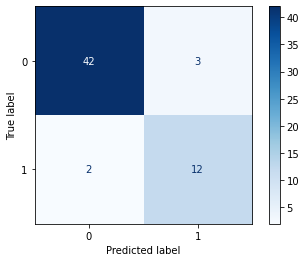

In [60]:
## This matrix visualization is based on 0.5 threshold
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [61]:
print("True Positive: %s" % tp)
print("False Pasitive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

True Positive: 12
False Pasitive: 3
True Negative: 42
False Negative: 2


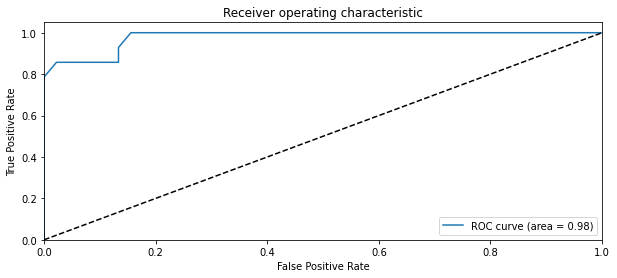

In [62]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Dump To Pickle

In [42]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

In [43]:
# feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Feature Importances')
# plt.ylabel('Feature Importance Score')
# plt.show()